In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 1000

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

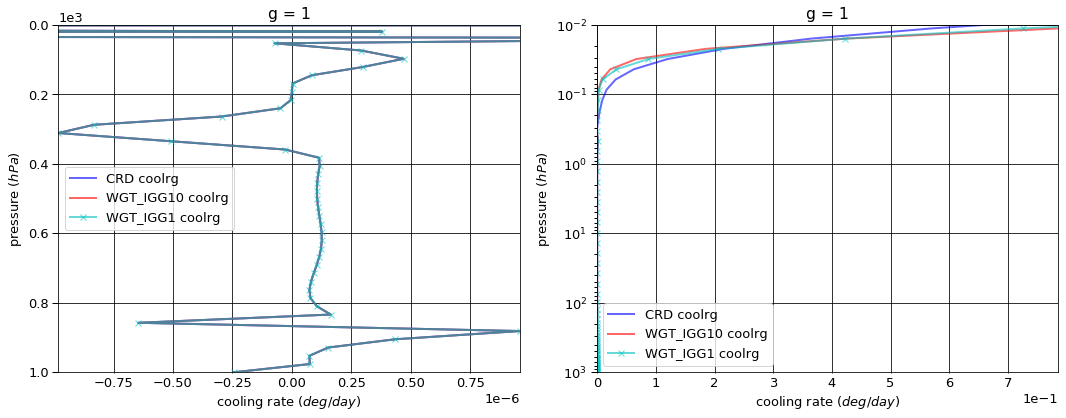

# Figure: cooling rate g-group 2

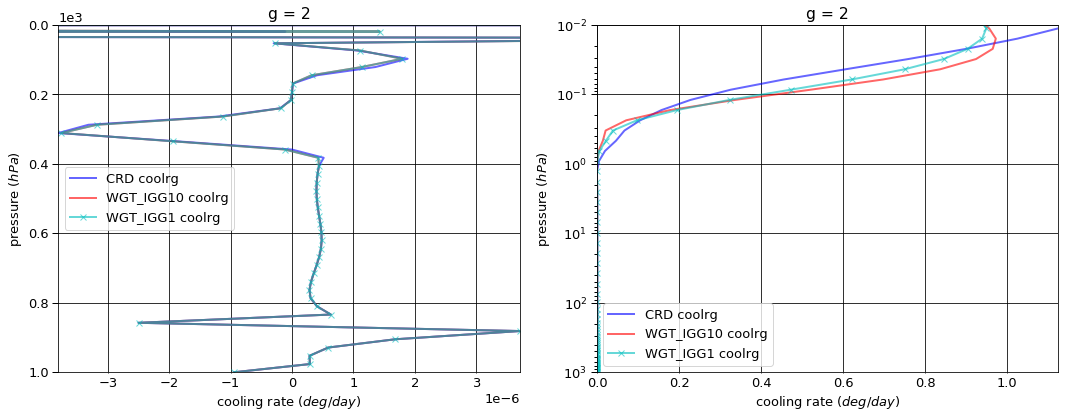

# Figure: cooling rate g-group 3

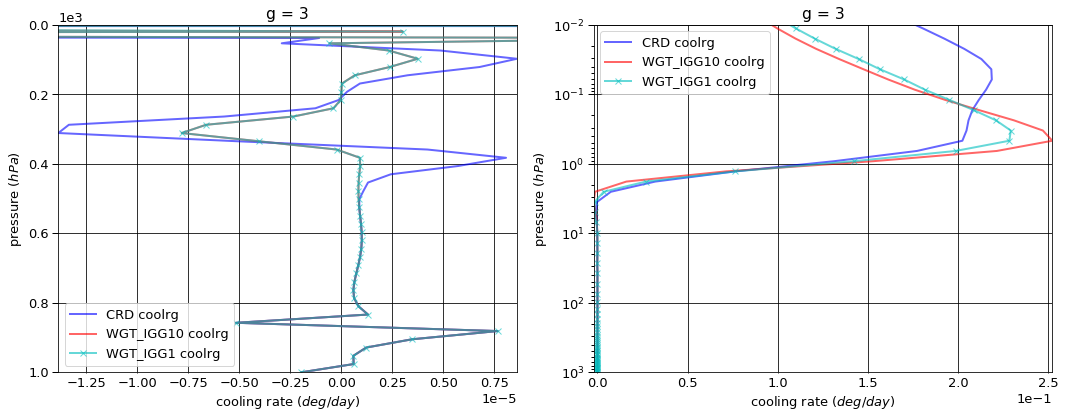

# Figure: cooling rate g-group 4

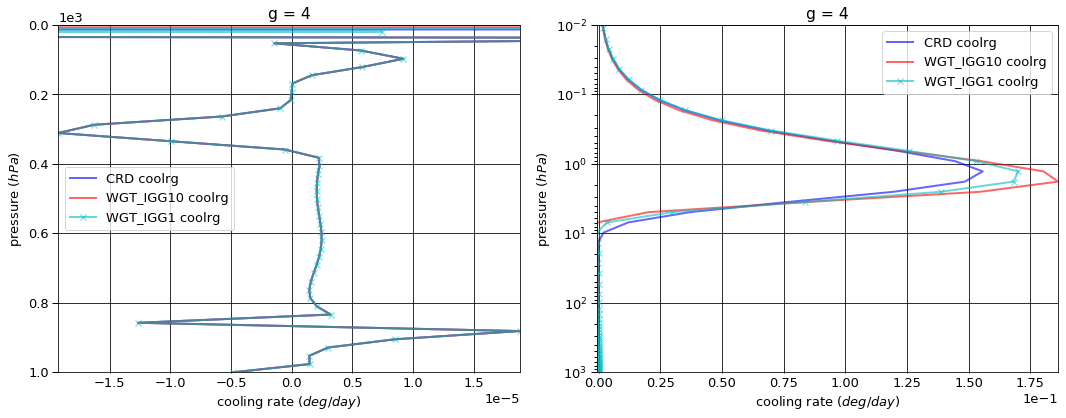

# Figure: cooling rate g-group 5

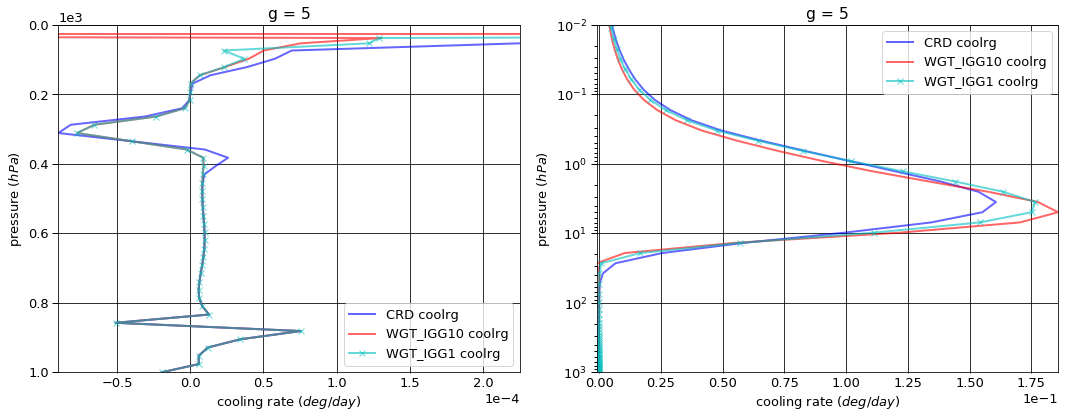

# Figure: cooling rate g-group 6

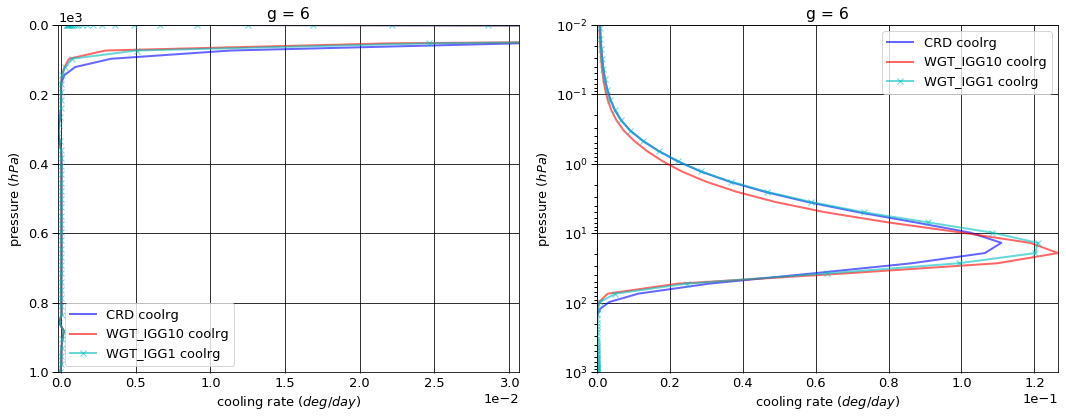

# Figure: cooling rate g-group 7

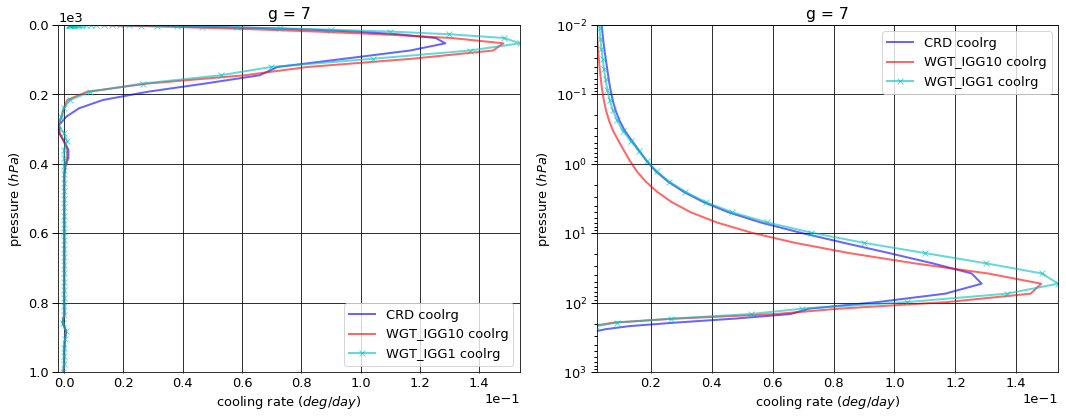

# Figure: cooling rate g-group 8

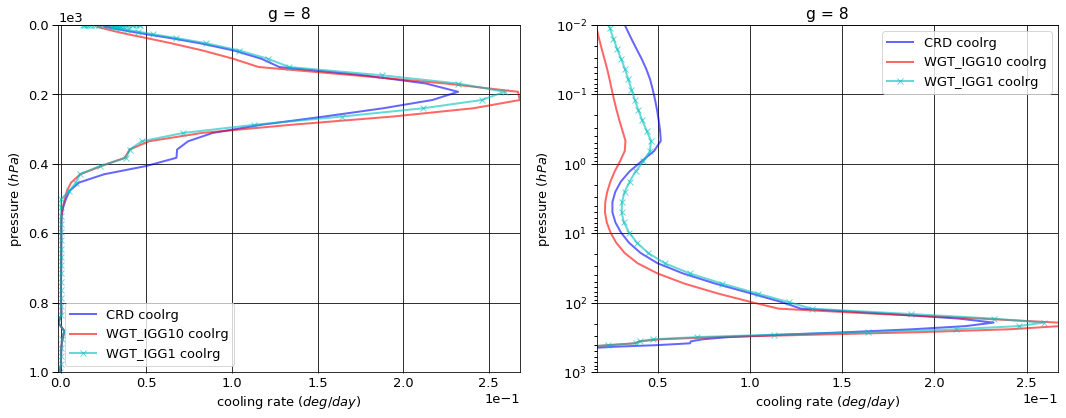

# Figure: cooling rate g-group 9

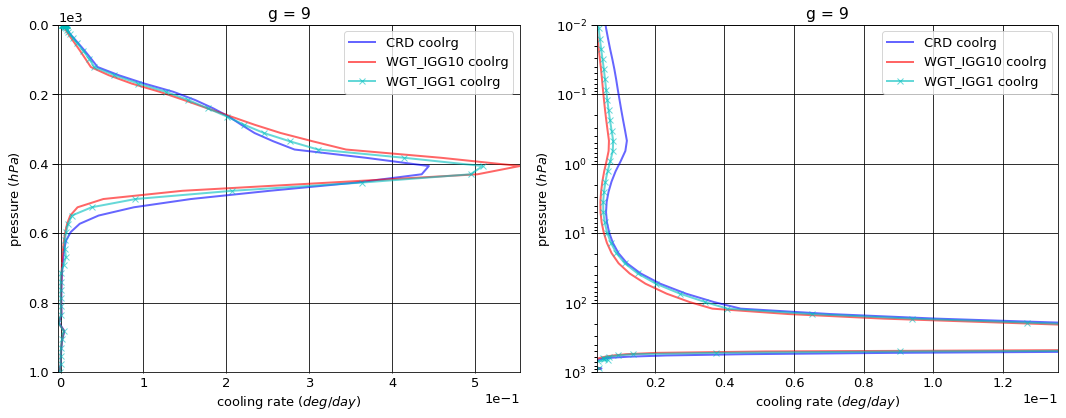

# Figure: cooling rate g-group 10

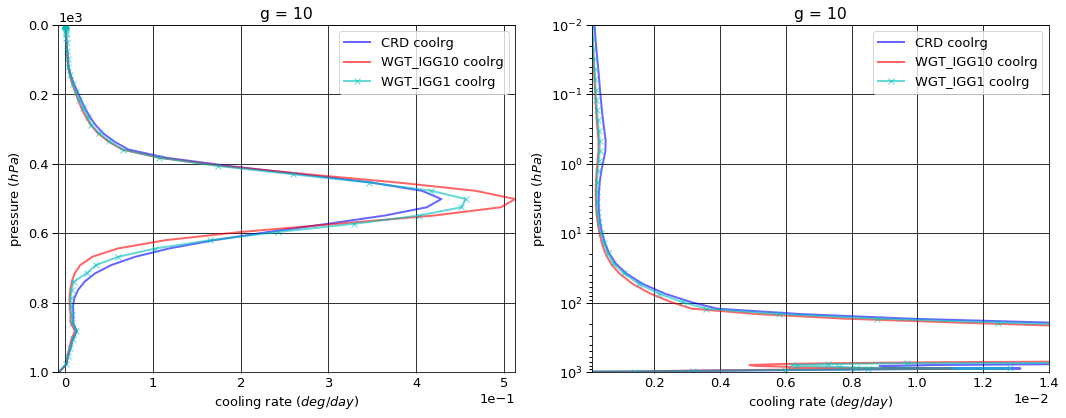

# Figure: cooling rate g-group total

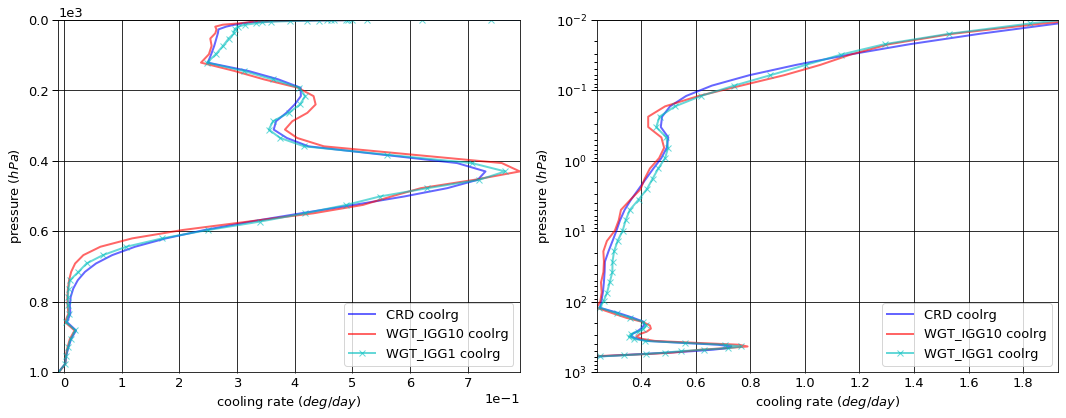

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003089   0.000000 -3.088913e-03
   1013.0   76     -0.003848   0.003849  8.429925e-07
2  0.0      1      -0.012729   0.000000 -1.272915e-02
   1013.0   76     -0.013953   0.013956  3.259088e-06
3  0.0      1      -0.028997   0.000000 -2.899683e-02
   1013.0   76     -0.030357   0.030364  6.734662e-06
4  0.0      1      -0.064397   0.000000 -6.439715e-02
   1013.0   76     -0.074872   0.074889  1.652447e-05
5  0.0      1      -0.230909   0.000000 -2.309092e-01
   1013.0   76     -0.299605   0.299672  6.649854e-05
6  0.0      1      -0.528904   0.000000 -5.289037e-01
   1013.0   76     -0.725474   0.725634  1.600929e-04
7  0.0      1      -2.020540   0.000000 -2.020540e+00
   1013.0   76     -2.757356   2.757967  6.101298e-04
8  0.0      1      -6.165338   0.000000 -6.165338e+00
   1013.0   76     -8.282997   8.284841  1.843645e-03
9  0.0      1     -11.849748   0.000000 -1.184975e+01
   1013.0   76    -15.075935  15.081531  5.596452e-03
10 0.0      1     -11.040508   0.000000 -1.104051e+01
   1013.0   76    -12.997070  13.030327  3.325677e-02


WGT_IGG10


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003073   0.000000 -3.072686e-03
   1013.0   76     -0.003848   0.003849  8.429925e-07
2  0.0      1      -0.012733   0.000000 -1.273328e-02
   1013.0   76     -0.013953   0.013956  3.259088e-06
3  0.0      1      -0.029416   0.000000 -2.941613e-02
   1013.0   76     -0.030357   0.030364  6.734662e-06
4  0.0      1      -0.065418   0.000000 -6.541827e-02
   1013.0   76     -0.074872   0.074889  1.652447e-05
5  0.0      1      -0.232097   0.000000 -2.320971e-01
   1013.0   76     -0.299605   0.299672  6.649854e-05
6  0.0      1      -0.527084   0.000000 -5.270835e-01
   1013.0   76     -0.725474   0.725634  1.600929e-04
7  0.0      1      -2.017694   0.000000 -2.017694e+00
   1013.0   76     -2.757356   2.757967  6.101298e-04
8  0.0      1      -6.138340   0.000000 -6.138340e+00
   1013.0   76     -8.282997   8.284840  1.843173e-03
9  0.0      1     -11.736473   0.000000 -1.173647e+01
   1013.0   76    -15.075935  15.080063  4.127542e-03
10 0.0      1     -10.975984   0.000000 -1.097598e+01
   1013.0   76    -12.997070  13.023562  2.649113e-02


WGT_IGG1


flug       fldg         fnetg
g  pressure level                                    
1  0.0      1      -0.003071   0.000000 -3.070803e-03
   1013.0   76     -0.003848   0.003849  8.429925e-07
2  0.0      1      -0.012774   0.000000 -1.277384e-02
   1013.0   76     -0.013953   0.013956  3.259088e-06
3  0.0      1      -0.029218   0.000000 -2.921826e-02
   1013.0   76     -0.030357   0.030364  6.734662e-06
4  0.0      1      -0.065074   0.000000 -6.507371e-02
   1013.0   76     -0.074872   0.074889  1.652447e-05
5  0.0      1      -0.232163   0.000000 -2.321630e-01
   1013.0   76     -0.299605   0.299672  6.649854e-05
6  0.0      1      -0.528292   0.000000 -5.282922e-01
   1013.0   76     -0.725474   0.725634  1.600929e-04
7  0.0      1      -2.015711   0.000000 -2.015711e+00
   1013.0   76     -2.757356   2.757967  6.101298e-04
8  0.0      1      -6.135257   0.000000 -6.135257e+00
   1013.0   76     -8.282997   8.284840  1.843173e-03
9  0.0      1     -11.775001   0.000000 -1.177500e+01
   1013.0   76    -15.075935  15.079386  3.451041e-03
10 0.0      1     -11.029955   0.000000 -1.102995e+01
   1013.0   76    -12.997070  13.029533  3.246216e-02


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.622690e-05  0.000000e+00  1.622690e-05
   1013.0   76     0.000000e+00 -4.336809e-19  0.000000e+00
2  0.0      1     -4.125000e-06  0.000000e+00 -4.125000e-06
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
3  0.0      1     -4.193040e-04  0.000000e+00 -4.193040e-04
   1013.0   76    -3.469447e-18  3.469447e-18 -8.470329e-22
4  0.0      1     -1.021124e-03  0.000000e+00 -1.021124e-03
   1013.0   76     0.000000e+00  0.000000e+00  3.388132e-21
5  0.0      1     -1.187860e-03  0.000000e+00 -1.187860e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      1.820150e-03  0.000000e+00  1.820150e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.846100e-03  0.000000e+00  2.846100e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      2.699750e-02  0.000000e+00  2.699750e-02
   1013.0   76     0.000000e+00 -5.000000e-07 -4.724000e-07
9  0.0      1      1.132750e-01  0.000000e+00  1.132750e-01
   1013.0   76     1.776357e-15 -1.468000e-03 -1.468910e-03
10 0.0      1      6.452400e-02  0.000000e+00  6.452400e-02
   1013.0   76    -1.776357e-15 -6.765000e-03 -6.765639e-03


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1      1.810980e-05  0.000000e+00  1.810980e-05
   1013.0   76     0.000000e+00 -4.336809e-19  0.000000e+00
2  0.0      1     -4.468700e-05  0.000000e+00 -4.468700e-05
   1013.0   76     0.000000e+00  1.734723e-18  0.000000e+00
3  0.0      1     -2.214380e-04  0.000000e+00 -2.214380e-04
   1013.0   76    -3.469447e-18  3.469447e-18 -8.470329e-22
4  0.0      1     -6.765650e-04  0.000000e+00 -6.765650e-04
   1013.0   76     0.000000e+00  0.000000e+00  3.388132e-21
5  0.0      1     -1.253800e-03  0.000000e+00 -1.253800e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      6.115000e-04  0.000000e+00  6.115000e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      4.829300e-03  0.000000e+00  4.829300e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
8  0.0      1      3.008010e-02  0.000000e+00  3.008010e-02
   1013.0   76     0.000000e+00 -5.000000e-07 -4.724000e-07
9  0.0      1      7.474700e-02  0.000000e+00  7.474700e-02
   1013.0   76     1.776357e-15 -2.145000e-03 -2.145412e-03
10 0.0      1      1.055300e-02  0.000000e+00  1.055300e-02
   1013.0   76    -1.776357e-15 -7.940000e-04 -7.946030e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      4.896483e+00
   1001.112500 75    -2.448148e-07
2  0.000312    1      1.022095e+00
   1001.112500 75    -9.466025e-07
3  0.000312    1      8.493638e-02
   1001.112500 75    -1.955893e-06
4  0.000312    1      8.961062e-05
   1001.112500 75    -4.798969e-06
5  0.000312    1      1.305605e-03
   1001.112500 75    -1.931266e-05
6  0.000312    1      3.981520e-04
   1001.112500 75    -4.649363e-05
7  0.000312    1      2.005553e-03
   1001.112500 75    -1.771947e-04
8  0.000312    1      1.644224e-02
   1001.112500 75    -5.353199e-04
9  0.000312    1      2.816899e-03
   1001.112500 75    -1.603391e-03
10 0.000312    1      6.995106e-05
   1001.112500 75    -7.470447e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      2.857439e+00
   1001.112500 75    -2.448148e-07
2  0.000312    1      5.371645e-01
   1001.112500 75    -9.466025e-07
3  0.000312    1      4.284652e-02
   1001.112500 75    -1.955893e-06
4  0.000312    1      7.975982e-05
   1001.112500 75    -4.798969e-06
5  0.000312    1      1.258406e-03
   1001.112500 75    -1.931266e-05
6  0.000312    1      3.107933e-04
   1001.112500 75    -4.649363e-05
7  0.000312    1      1.172728e-03
   1001.112500 75    -1.771947e-04
8  0.000312    1      9.015908e-03
   1001.112500 75    -5.352990e-04
9  0.000312    1      1.555320e-03
   1001.112500 75    -1.190034e-03
10 0.000312    1      3.821736e-05
   1001.112500 75    -6.943391e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      3.390658e+00
   1001.112500 75    -2.448148e-07
2  0.000312    1      6.125386e-01
   1001.112500 75    -9.466025e-07
3  0.000312    1      4.798964e-02
   1001.112500 75    -1.955893e-06
4  0.000312    1      8.527252e-05
   1001.112500 75    -4.798969e-06
5  0.000312    1      1.421839e-03
   1001.112500 75    -1.931266e-05
6  0.000312    1      3.807947e-04
   1001.112500 75    -4.649363e-05
7  0.000312    1      1.669802e-03
   1001.112500 75    -1.771947e-04
8  0.000312    1      1.287173e-02
   1001.112500 75    -5.352990e-04
9  0.000312    1      1.850342e-03
   1001.112500 75    -1.002313e-03
10 0.000312    1      4.390670e-05
   1001.112500 75    -7.893822e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.039044e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.849305e-01
   1001.112500 75    -1.058791e-22
3  0.000312    1     -4.208986e-02
   1001.112500 75     4.235165e-22
4  0.000312    1     -9.850802e-06
   1001.112500 75    -8.470329e-22
5  0.000312    1     -4.719910e-05
   1001.112500 75     0.000000e+00
6  0.000312    1     -8.735865e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -8.328256e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -7.426333e-03
   1001.112500 75     2.094000e-08
9  0.000312    1     -1.261579e-03
   1001.112500 75     4.133566e-04
10 0.000312    1     -3.173370e-05
   1001.112500 75     5.270559e-04


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.505824e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -4.095564e-01
   1001.112500 75    -1.058791e-22
3  0.000312    1     -3.694674e-02
   1001.112500 75     4.235165e-22
4  0.000312    1     -4.338097e-06
   1001.112500 75    -8.470329e-22
5  0.000312    1      1.162344e-04
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.735732e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -3.357511e-04
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.570514e-03
   1001.112500 75     2.094000e-08
9  0.000312    1     -9.665568e-04
   1001.112500 75     6.010781e-04
10 0.000312    1     -2.604436e-05
   1001.112500 75    -4.233745e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.945159,0.000000,-31.945159
1013.0,76,-40.261468,40.303028,0.041561



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.738312,0.000000,-31.738312
1013.0,76,-40.261468,40.294795,0.033326



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.826516,0.000000,-31.826516
1013.0,76,-40.261468,40.300089,0.038620



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.206847,0.000000,0.206847
1013.0,76,0.000000,-0.008233,-0.008235



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.118643,0.00000,0.118643
1013.0,76,0.000000,-0.00294,-0.002940


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,6.026642
1001.112500,75,-0.009860



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,3.450881
1001.112500,75,-0.008920



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,4.069510
1001.112500,75,-0.009682



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.575761
1001.112500,75,0.000940



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.957132
1001.112500,75,0.000178


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000109,0.000096
2,0.000341,0.000347
3,0.000884,0.000756
4,0.002078,0.001866
5,0.008837,0.007466
6,0.020303,0.018082
7,0.082453,0.068733
8,0.239828,0.206380
9,0.400194,0.375109


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.441550e-16
2,3.621082e-17
3,3.809979e-18
4,9.034937e-18
5,9.970460e-19
6,9.178721e-19
7,1.059911e-19
8,1.223930e-20
9,1.413330e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.441550e-16,NaN,0.000109,0.000096,0.000109,0.000096,1.0
2,3.621082e-17,0.105217,0.000341,0.000347,0.000450,0.000443,1.0
3,3.809979e-18,0.105217,0.000884,0.000756,0.001334,0.001199,1.0
4,9.034937e-18,2.371387,0.002078,0.001866,0.003413,0.003065,30.0
5,9.970460e-19,0.110355,0.008837,0.007466,0.012250,0.010531,30.0
6,9.178721e-19,0.920592,0.020303,0.018082,0.032553,0.028613,300.0
7,1.059911e-19,0.115475,0.082453,0.068733,0.115006,0.097346,300.0
8,1.223930e-20,0.115475,0.239828,0.206380,0.354834,0.303726,300.0
9,1.413330e-21,0.115475,0.400194,0.375109,0.755028,0.678835,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.175478e-15  4.903234e-16   2.397353  5.926108e-02
      2  0.000312     6.288076e-17  3.010178e-17   2.088938  3.400951e-03
      3  0.000312     2.654895e-18  1.076714e-18   2.465738  1.320141e-04
      4  0.000312     9.745557e-22  9.493947e-22   1.026502  8.149436e-08
      5  0.000312     4.010834e-21  3.119599e-21   1.285689  2.884382e-07
      6  0.000312     4.191608e-22  3.057101e-22   1.371106  2.893310e-08
      7  0.000312     5.674613e-22  1.214475e-22   4.672480  3.313243e-08
      8  0.000312     1.656140e-21  5.183013e-23  31.953233  8.638884e-08
      9  0.000312     1.398673e-22  5.148531e-24  27.166448  7.322137e-09
      10 0.000312     4.751823e-24  3.867856e-25  12.285418  2.559780e-10
2     1  0.000750     1.174492e-15  4.936226e-16   2.379333  2.393864e-02
      2  0.000750     6.382740e-17  3.050140e-17   2.092606  1.389195e-03
      3  0.000750     2.711252e-18  1.097317e-18   2.470801  5.424816e-05
      4  0.000750     1.494636e-21  1.469326e-21   1.017226  5.066094e-08
      5  0.000750     4.254357e-21  3.297472e-21   1.290187  1.229560e-07
      6  0.000750     4.279357e-22  3.131057e-22   1.366745  1.192174e-08
      7  0.000750     5.756986e-22  1.235477e-22   4.659728  1.354365e-08
      8  0.000750     1.678534e-21  5.249208e-23  31.976907  3.526625e-08
      9  0.000750     1.422813e-22  5.229601e-24  27.206915  3.000055e-09
      10 0.000750     4.860400e-24  3.940747e-25  12.333701  1.054392e-10
3     1  0.001052     1.172614e-15  5.000821e-16   2.344843  3.376162e-02
      2  0.001052     6.573701e-17  3.127873e-17   2.101652  2.001920e-03
      3  0.001052     2.824758e-18  1.133740e-18   2.491540  7.894135e-05
      4  0.001052     1.877233e-21  1.851840e-21   1.013712  8.944796e-08
      5  0.001052     4.692899e-21  3.587418e-21   1.308155  1.885238e-07
      6  0.001052     4.391286e-22  3.213996e-22   1.366301  1.715969e-08
      7  0.001052     5.920258e-22  1.267403e-22   4.671172  1.952610e-08
      8  0.001052     1.725830e-21  5.364888e-23  32.168983  5.084422e-08
      9  0.001052     1.473685e-22  5.377307e-24  27.405629  4.356905e-09
      10 0.001052     5.093472e-24  4.077050e-25  12.493035  1.548558e-10
4     1  0.001476     1.170601e-15  5.065723e-16   2.310828  4.762975e-02
      2  0.001476     6.770156e-17  3.207809e-17   2.110524  2.886012e-03
      3  0.001476     2.946167e-18  1.172000e-18   2.513795  1.150116e-04
      4  0.001476     2.405633e-21  2.380121e-21   1.010719  1.611393e-07
      5  0.001476     5.191907e-21  3.909981e-21   1.327860  2.898190e-07
      6  0.001476     4.520643e-22  3.312793e-22   1.364602  2.480179e-08
      7  0.001476     6.098957e-22  1.302637e-22   4.682009  2.821169e-08
      8  0.001476     1.776890e-21  5.487377e-23  32.381413  7.342949e-08
      9  0.001476     1.528489e-22  5.532280e-24  27.628550  6.338357e-09
      10 0.001476     5.352371e-24  4.220479e-25  12.681905  2.281162e-10
5     1  0.002070     1.168461e-15  5.130135e-16   2.277641  6.717085e-02
      2  0.002070     6.969740e-17  3.289193e-17   2.118982  4.158480e-03
      3  0.002070     3.074645e-18  1.212072e-18   2.536685  1.676171e-04
      4  0.002070     3.136687e-21  3.110987e-21   1.008261  2.951965e-07
      5  0.002070     5.756819e-21  4.268529e-21   1.348666  4.462942e-07
      6  0.002070     4.672210e-22  3.432648e-22   1.361109  3.601120e-08
      7  0.002070     6.292914e-22  1.341959e-22   4.689348  4.081975e-08
      8  0.002070     1.831357e-21  5.616946e-23  32.604147  1.061336e-07
      9  0.002070     1.586888e-22  5.694154e-24  27.868723  9.227888e-09
      10 0.002070     5.636894e-24  4.371141e-25  12.895704  3.366819e-10
6     1  0.002904     1.166172e-15  5.194105e-16   2.245183  9.472647e-02
      2  0.002904     7.172510e-17  3.372328e-17   2.126872  5.991292e-03
      3  0.002904     3.210860e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
